#**HW7: Point Models**
*CS4610/5335: Robotic Science and Systems (Spring 2023) | Robert Platt | Northeastern University*

--------------------------

Please remember the following policies:
- Submissions should be made electronically via the Canvas. For this assignment, you should submit both a *.ipynb and *.pdf version of your completed Colab notebook as a single zipped file.
- You are welcome to discuss the programming questions (but not the written questions) with other students in the class. However, you must understand and write all code yourself. Also, you must list all students (if any)
with whom you discussed your solutions to the programming questions.
- Please provide comments in your code to make it understandable to the graders. 

<style type="text/css">
    ol { list-style-type: upper-alpha; }
</style>

---

*By defualt, the notebook is on CPU runtime.  Due to restrictions on GPU-usage, we recommend switching to GPU runtime only when you are ready to train the models, and ending the runtime session when not in use.  You can make these changes using the 'Runtime' tab on the top panel.*

---

Programming Partners: Aditya Bondada, Mani Chandhan Chakinala


# Utils and Imports
Run the code cells below before you start working on the rest of the notebook.

In [ ]:
%%capture
! pip install plotly scikit-learn scipy
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=12SKS8uRk_w5xi5b45ipX7lFW6GLfAbjY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=12SKS8uRk_w5xi5b45ipX7lFW6GLfAbjY" -O mug_partnet.npz && rm -rf /tmp/cookies.txt

In [ ]:
from typing import Tuple
import numpy as np
import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader, random_split
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation

In [ ]:
def plot_pointcloud(pc, labels, preds, grasp_pose=None):
  cmap_bwr = [[0, 'rgb(0,50,255)'], [0.5, 'rgb(200,200,200)'], [1, 'rgb(255,50,0)']]
  traces = [
    go.Scatter3d(
      x=pc[..., 0].flatten() - 1,
      y=pc[..., 1].flatten(),
      z=pc[..., 2].flatten(),
      mode='markers',
      marker=dict(
          size=6,
          color=labels.flatten(),
          colorscale=cmap_bwr, 
      ),
    ),
    go.Scatter3d(
      x=pc[..., 0].flatten() + 1,
      y=pc[..., 1].flatten(),
      z=pc[..., 2].flatten(),
      mode='markers',
      marker=dict(
          size=6,
          color=preds.flatten(),
          colorscale=cmap_bwr, 
      ),
    )
  ]
  if grasp_pose is not None:
    gripper_lines = np.array([
      [0, 0, -0.2],
      [0, -0.3, -0.2],
      [0, -0.3, 0],
      [0, -0.5, 0],
      [0, -0.3, 0],
      [0, -0.3, 0.2],
      [0, 0, 0.2],
    ])
    gripper_lines = (grasp_pose[:3, :3] @ gripper_lines.T).T + grasp_pose[:3, 3]
    traces.append(
      go.Scatter3d(
        x=gripper_lines[:, 0] + 1,
        y=gripper_lines[:, 1],
        z=gripper_lines[:, 2],
        mode='lines',
        line=dict(width=20),
        name='grasp'
      ),
    )

  fig = go.Figure(
    data=traces,
    layout=dict(
      scene=dict(
        xaxis=dict(range=[-2.1, 2.1]),
        yaxis=dict(range=[-1.1, 1.1]),
        zaxis=dict(range=[-1.1, 1.1]),
        aspectmode='manual',
        aspectratio=dict(x=4, y=2, z=2),
        camera=dict(
          up=dict(x=0, y=0, z=1),
          center=dict(x=0, y=0, z=0),
          eye=dict(x=0, y=-5, z=5),
          projection=dict(type='orthographic'),
        ),
      ),
      width=1000,
      height=500,
      margin=dict(l=0, r=0, t=0, b=0),
      plot_bgcolor="rgba(0,0,0,0)",
      paper_bgcolor="rgba(0,0,0,0)",
    )
  )
  fig.show()

def q1a_checker(tnet: nn.Module):
  num_params = sum(p.numel() for p in tnet(3).parameters() if p.requires_grad)
  assert num_params == 799113, (
      f'Incorrect number of parameters. Expected 799113, found {num_params}.'
  )
  
  x = torch.randn((1, 3, 127))
  out = tnet(k=3)(x)
  assert out.shape == (1, 3, 3), (
      f'Incorrect output shape. Expected (3, 3), found {out.shape[1:]}.'
  )

  x = torch.randn((1, 64, 317))
  out = tnet(k=64)(x)
  assert out.shape == (1, 64, 64), (
      f'Incorrect output shape. Expected (64, 64), found {out.shape[1:]}.'
  )
  print('Q1a: PASSED')


def q1b_checker(pnet: nn.Module):
  net = pnet()

  num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
  assert num_params == 2801481, (
      f'Incorrect number of parameters. Expected 2801481, found {num_params}.'
  )
  
  net = pnet()
  x = torch.randn((1, 3, 163))
  gfeat, lfeat, _, _ = net(x)
  assert gfeat.shape == (1, 1024), (
      f'Incorrect global feature shape. Expected (1024, ), found {gfeat.shape[1:]}.'
  )

  assert lfeat.shape == (1, 64, 163), (
      f'Incorrect local feature shape. Expected (64, 163), found {lfeat.shape[1:]}.'
  )

  x_shuffled = x[:, :, torch.randperm(163)]
  gfeat_shuffled, lfeat_shuffled, _, _ = net(x_shuffled)
  assert torch.allclose(gfeat, gfeat_shuffled), (
      f'Incorrect implementation, expected global features to be invariant to point ordering.'
  )

  print('Q1b: PASSED')

# Q1. Implementing [PointNet](https://openaccess.thecvf.com/content_cvpr_2017/papers/Qi_PointNet_Deep_Learning_CVPR_2017_paper.pdf) [3 pts]
In this question, you will implement the backbone of PointNet (e.g. everything except the prediction head).  There are checker functions that can be used as a sanity check that your implementation is correct.

a.   Implement the TNet module below.  See the docstring for more information.

b.   Implement the PointNetBackbone module below.  The backbone should implement all operations shown in the image below.  Place a ReLU between each linear operation in the MLPs.  See docstring for what parameters to return.

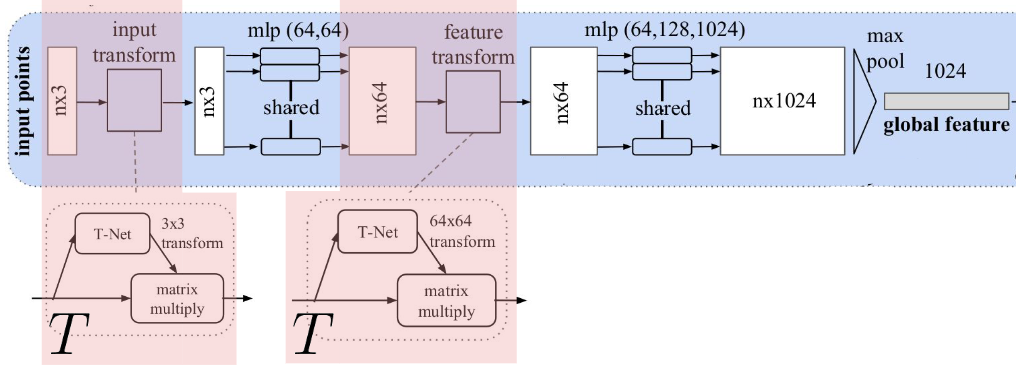

c.   Why is invariance to ordering an important property for a point cloud network?  What makes PointNet invariant to the order of the points in the input?

For a point cloud network, being invariant to the ordering of points is crucial because the order of the points in the input is arbitrary, and different point clouds can represent the same object with different point orders. This means that a network that is sensitive to point ordering will not perform well when presented with new point clouds with different point orders. 

PointNet overcomes this issue by using a max pooling operation that extracts a global feature vector from the entire point cloud, and this vector is insensitive to the order of the points. Furthermore, PointNet employs a symmetric function in the MLP layers, ensuring that the output is independent of the order of the inputs. These design choices make PointNet invariant to the order of the points in the input and enable it to generalize well to new point clouds with varying point orders.



In [ ]:
class TNet(nn.Module):
  def __init__(self, k: int):
    '''Module that predicts a k-by-k transformation matrix 

    The layers are described below.  Please follow this description, even though
    it differs slightly from what was presented in lecture.  Do not use batchnorms
    anywhere in this module:

    1. SharedMLP: three linear layers with output dimensions of 64, 128, and 1024, 
                  respectively.  Include relu's after each linear operation
    2. Max pool operation over all points (dim=1)
    3. Flatten operation to generate tensor of shape (batch_size, 1024)
    4. MLP: three linear layers with output dimensions of 512, 256, and k*k, respectively.
            Include ReLU's *between* the layers (NOT ON OUTPUT!)
    5. Reshape operation to produce tensor of shape (batch_size, k, k)

    Hint
    ----
    `nn.Conv1d` is a simple way to share the same linear operation 
    '''
    super().__init__()
    self.k = k

    self.shared_mlp = nn.Sequential(
        nn.Conv1d(k, 64, 1),
        nn.ReLU(),
        nn.Conv1d(64, 128, 1),
        nn.ReLU(),
        nn.Conv1d(128, 1024, 1),
        nn.ReLU()
    )

    self.mlp = nn.Sequential(
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, k*k)
    )

  def forward(self, x: Tensor):
    '''Performs forward pass

    Arguments
    ---------
    x : tensor of shape (B, 3, N) where B is batch size
        and N is the number of points
    
    Returns
    -------
    tensor of shape (B, self.k, self.k)
    '''
    x = self.shared_mlp(x)
    x = torch.max(x, 2, keepdim=True)[0]
    x = x.view(-1, 1024)
    x = self.mlp(x)
    x = x.view(-1, self.k, self.k)
    return x

class PointNetBackbone(nn.Module):
  def __init__(self):
    '''PointNet network without predictions head, see picture for more information.

    USE ReLU BETWEEN ALL LINEAR LAYERS IN MLP!! For instance, "mlp(64,64)" 
    corresponds to two linear operations with output dimensions of 64 and 64, 
    with a ReLU between them
    '''
    super().__init__()

    self.input_transform = TNet(3)
    self.shared_mlp_1 = nn.Sequential(
        nn.Conv1d(3, 64, 1),
        nn.ReLU(),
        nn.Conv1d(64, 64, 1),
    )
    self.feature_transform = TNet(64)
    self.shared_mlp_2 = nn.Sequential(
        nn.Conv1d(64, 64, 1),
        nn.ReLU(),
        nn.Conv1d(64, 128, 1),
        nn.ReLU(),
        nn.Conv1d(128, 1024, 1),
    )

  def forward(self, x: Tensor) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
    '''Perform forward pass, returning additional intermediate features which are
    needed for subsequent processing or computing loss terms

    Arguments
    ---------
    x : point cloud, float tensor of shape (B, 3, N)

    Returns
    -------
    global_feature: float tensor of shape (B, 1024) generated by max pool operation
    point_features: float tensor of shape (B, 64, N), features produced by feature
                    transform operation
    input_transform: float tensor of shape (B, 3, 3); input transformation matrix
                     produced by first TNet module
    feature_transform: float tensor of shape (B, 64, 64); feature transformation matrix
                     produced by second TNet module
    '''
    input_transform_out = self.input_transform(x)
    x = torch.einsum('abc,abd->adc', x, input_transform_out)

    point_features = self.shared_mlp_1(x)
    feature_transform_out = self.feature_transform(point_features)
    x = torch.einsum('abc,abd->adc', point_features, feature_transform_out)

    x = self.shared_mlp_2(x)
    global_feature = torch.max(x, 2, keepdim=True)[0].view(-1, 1024)
    return global_feature, point_features, input_transform_out, feature_transform_out

q1a_checker(TNet)
q1b_checker(PointNetBackbone)

Q1a: PASSED
Q1b: PASSED


# Q2. PointNet for Segmentation [4 pts]
The output of the PointNet backbone is a global feature vector. As discussed in class, this can be used to make predictions about the entire point cloud.  For this assignment, we want the ability to make predictions on a point-by-point basis.  For instance, given a point cloud of a coffee mug, we want the network to predict which points belong to the handle.  In this question, you will implement a PointNet model for point cloud segmentation, implement auxilliary loss functions and then train it to segment coffee mug handles.

a.   Implement the PointNetSeg module below (`__init__` and `forward` methods).  This network broadcasts the global feature vector to all point-wise features then performs additional point-wise processing. See picture below for more information (you already implemented the top row with `PointNetBackbone`)
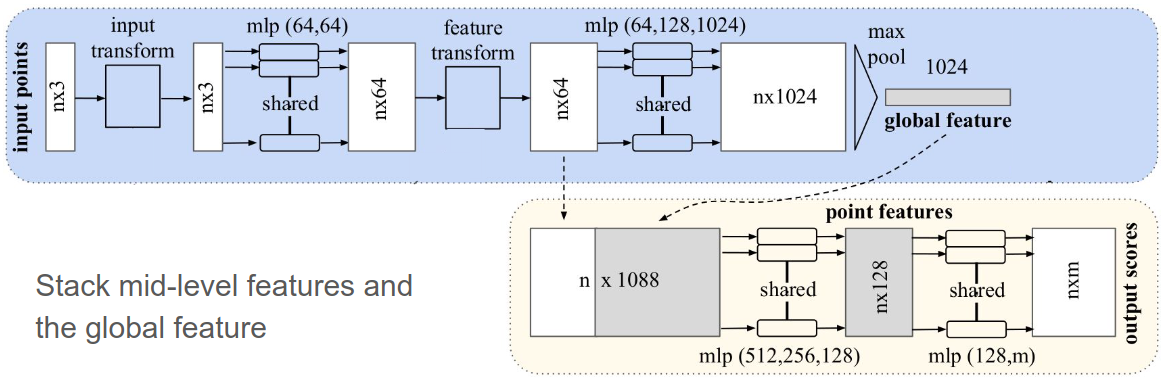

b.   Complete the `compute_losses` method, which applies a cross entropy loss to predict better class scores and a regularization loss to push the learned transformation matrices to be orthogonal.

c.   We are almost ready for training.  The dataset has been defined for you below.  Notice that the point cloud is transformed so its center of mass is zero and the maximum magnitude is 1.  Why is it smart to center and normalize the point cloud in this way before passing it as input to the network?  Consider how this changes the networks ability to generalize.

Normalizing and centering the point cloud before passing it through the network has several benefits:

Scale invariance: Normalization guarantees a consistent scale for all input samples, allowing the network to be scale-invariant and perform well on point clouds with different scales. Networks without normalization might have difficulties learning meaningful features from point clouds with different scales.

Numerical stability: Centering and normalization help avoid numerical instability problems during training. Because the input data values fall within a similar range, the gradients and activations within the network are more likely to be stable, preventing issues like vanishing or exploding gradient.

Better convergence: Normalized inputs can enhance the optimization process by allowing the network to converge more quickly. This is due to the fact that the gradients and weight updates are more consistent, resulting in fewer oscillations and fewer occurrences of getting stuck in local minima.

Generalization: Centering and normalization make sure that the network focuses on learning the underlying structure and patterns of the point cloud data, rather than being influenced by specific scales or positions. This makes the learned features more resilient and improves the network's ability to generalize to new and unseen data.

d.   Run the code cell to train the network for 20 epochs then plot the predictions.  Uncomment the section in the prediction code to test how the network does on a subset of the point cloud.  How does the network perform on the subset compared to the full point cloud?  

The predictions from the network are better for the subset of the point cloud compared to the full point cloud

In [ ]:
class PointNetSeg(nn.Module):
  def __init__(self, num_classes: int):
    '''PointNet model with dense output that predicts per-pixel class labels

    Use the PointNetBackbone.  First broadcast the global feature to every point
    then concatenate the global features and point features to create a (B, 1088, N)
    tensor.  Then use a shared MLP to generate the output scores: a tensor of 
    shape (B, num_classes, N)
    '''
    super().__init__()
    self.backbone = PointNetBackbone()
    self.mlp = nn.Sequential(
        nn.Conv1d(1088, 512, 1),
        nn.ReLU(),
        nn.Conv1d(512, 256, 1),
        nn.ReLU(),
        nn.Conv1d(256, 128, 1),
        nn.ReLU(),
        nn.Conv1d(128, num_classes, 1)
    )

  def forward(self, x: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
    '''Perform forward pass

    Arguments
    ---------
    x: point cloud, float tensor of shape (B, 3, N)

    Returns
    -------
    tuple:
      output_scores: float tensor of per-point logits; shape (B, num_classes, N)
      input_transform: float tensor of shape (3, 3); provided by PointNetBackbone.forward
      feature_transform: float tensor of shape (64, 64); provided by PointNetBackbone.forward
    '''
    gfeat, pfeat, inp_t, fea_t = self.backbone(x)
    gfeat = gfeat.unsqueeze(-1).expand(-1, -1, x.size(2))

    x = torch.cat([gfeat, pfeat], dim=1)
    x = self.mlp(x)
    return x, inp_t, fea_t

  @torch.no_grad()
  def predict(self, x: Tensor):
    '''Predict class labels for each point in point cloud

    Arguments
    ---------
    x: point cloud, float tensor of shape (B, 3, N)

    Returns
    -------
    per-point class labels, long tensor of shape (B, N)
    '''
    out = self.forward(x)[0]
    return torch.argmax(out, dim=1)

  def compute_losses(self, x: Tensor, labels: Tensor) -> Tuple[Tensor, Tensor]:
    '''Compute losses

    Arguments
    ---------
    x: point cloud, float tensor of shape (B, 3, N)
    labels: per-point class labels, long tensor of shape (B, N)

    Returns
    -------
    tuple:
      cls_loss: classification loss generated by `nn.CrossEntropy()(output_scores, labels)`
      ortho_loss: regularization loss that penalizes transformation matrices that are not orthogonal.
                  It is computed as $$L = \|I - AA^T\|^2_F$$. In other words, take the frobenius norm
                  of an Identity matrix minus the outer product of the transformation matrix.  Return the 
                  sum of the loss computed for the input_transform matrix and the feature_transform matrix.
                  Hint: use `torch.linalg.matrix_norm` to compute frobenius norm
    '''
    scores, tfm3x3, tfm64x64 = self.forward(x)
    cls_loss = nn.CrossEntropyLoss()(scores, labels)

    I3 = torch.eye(3)
    I64 = torch.eye(64)
    ortho_loss = torch.norm(I3 - torch.bmm(tfm3x3, tfm3x3.transpose(1, 2))) + torch.norm(I64 - torch.bmm(tfm64x64, tfm64x64.transpose(1, 2)))
    return cls_loss, ortho_loss

In [ ]:
class PointCloudDataset(Dataset):
  def __init__(self, path, pc_size: int = 1024):
    '''Dataset including point clouds with labeled per-point classes
    
    Each point cloud has 2048 points, but they are randomly downsampled to
    `pc_size` when accessed by data loader
    '''
    data = np.load(path, allow_pickle=True)
    self.pcs = data['pc']
    self.segs = data['seg']

    self.pc_size = pc_size

  def __getitem__(self, idx: int):
    '''Retrieve point cloud with segmentation labels, point clouds are centered
    at (0,0,0) and normalized such that all points lie within the unit sphere

    Returns
    -------
    pc : float tensor of shape (3, pc_size), point cloud
    seg : long tensor of shape (pc_size, ), segmentation labels
    '''
    pc = self.pcs[idx]
    seg = self.segs[idx]

    # take random subset of full pointcloud
    indices = np.arange(len(pc))
    np.random.shuffle(indices)
    indices = indices[:self.pc_size]
    pc = pc[indices]
    seg = seg[indices]

    # add gaussian noise
    pc += 0.02 * np.random.random(size=pc.shape)

    # randomly rotate about z-axis
    theta = np.random.uniform(0, 2*np.pi)
    rot_mtx = np.array((
        (np.cos(theta), -np.sin(theta), 0),
        (np.sin(theta), np.cos(theta), 0),
        (0, 0, 1),
    ))
    pc = np.einsum('ni,ji->nj', pc, rot_mtx)

    # center and normalize point cloud
    pc = pc - pc.mean(axis=0)
    pc /= np.linalg.norm(pc, axis=1, keepdims=True).max(axis=0, keepdims=True)

    # convert to tensors
    pc = torch.from_numpy(pc.T).float()
    seg = torch.from_numpy(seg.T).long()

    return pc, seg

  def __len__(self):
    return self.pcs.shape[0]

In [ ]:
# This code cell trains the network
generator = torch.Generator().manual_seed(42)
train_set, test_set = random_split(
    PointCloudDataset('mug_partnet.npz', pc_size=1024),
    lengths=[0.8, 0.2],
    generator=generator,
)
train_dl = DataLoader(train_set, batch_size=12, shuffle=True, num_workers=2)
test_dl = DataLoader(test_set, batch_size=12, shuffle=False, num_workers=2)

model = PointNetSeg(num_classes=2)

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-3
)

# parameter balancing two loss terms
gamma = 0.05

num_epochs = 20

device = 'cuda' if torch.cuda.is_available() else 'cpu'
for epoch_id in range(num_epochs):
  train_losses = []
  model.train()
  for pc, lbl in train_dl:
    pc = pc.to(device)
    lbl = lbl.to(device)

    cls_loss, ortho_loss = model.compute_losses(pc, lbl)
    loss = cls_loss + gamma * ortho_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

  test_losses = []
  model.eval()
  for pc, lbl in test_dl:
    pc = pc.to(device)
    lbl = lbl.to(device)

    with torch.no_grad():
      cls_loss, ortho_loss = model.compute_losses(pc, lbl)
      loss = cls_loss + gamma * ortho_loss

    test_losses.append(loss.item())
  
  train_loss = np.mean(train_losses)
  test_loss = np.mean(test_losses)

  print(f'Epoch={epoch_id} | Train loss={train_loss:.4f} | Test loss={test_loss:.4f}')

Epoch=0 | Train loss=1.3557 | Test loss=0.7718
Epoch=1 | Train loss=0.5681 | Test loss=0.4544
Epoch=2 | Train loss=0.3866 | Test loss=0.3265
Epoch=3 | Train loss=0.3224 | Test loss=0.5437
Epoch=4 | Train loss=0.4308 | Test loss=0.3353
Epoch=5 | Train loss=0.3516 | Test loss=0.4188
Epoch=6 | Train loss=0.3330 | Test loss=0.4190
Epoch=7 | Train loss=0.3131 | Test loss=0.2948
Epoch=8 | Train loss=0.2555 | Test loss=0.2482
Epoch=9 | Train loss=0.2534 | Test loss=0.3154
Epoch=10 | Train loss=0.3004 | Test loss=0.3726
Epoch=11 | Train loss=0.2586 | Test loss=0.2815
Epoch=12 | Train loss=0.2528 | Test loss=0.1901
Epoch=13 | Train loss=0.1866 | Test loss=0.2335
Epoch=14 | Train loss=0.2166 | Test loss=0.3415
Epoch=15 | Train loss=0.2268 | Test loss=0.2624
Epoch=16 | Train loss=0.1931 | Test loss=0.1679
Epoch=17 | Train loss=0.1598 | Test loss=0.1796
Epoch=18 | Train loss=0.1576 | Test loss=0.1869
Epoch=19 | Train loss=0.1543 | Test loss=0.1391


In [ ]:
# plot predictions from test set
i = np.random.randint(len(test_set))
pc, lbl = test_set[i]

## UNCOMMENT THIS TO DOWNSAMPLE PC
subset_size = 512
subset_ind = np.random.choice(np.arange(pc.shape[-1]), size=subset_size, replace=False)
pc = pc[:, subset_ind]
lbl = lbl[subset_ind]

pc = pc.unsqueeze(0).to(device)
with torch.no_grad():
  pred = torch.softmax(model.forward(pc)[0], dim=1)[:, 1]

plot_pointcloud(
    pc[0].cpu().numpy().T,
    preds=pred[0].cpu().numpy().T,
    labels=lbl.numpy().T
)

# Q3. Heuristic Grasping using Segmentation Output [2 pt]

a.   In the code cell below, a heuristic is used to generate a grasp pose that grips the mug by the handle.  Run the code cells to visualize grasp predictions for two cases: mug is upright and mug on its side.  Are the predictions good?  Why do you think it fails when the mug is not upright?

When the mug is upright, the grasp prediction algorithm can work well due to the easy identification of the handle, enabling the generation of an appropriate grasp pose. The handle is a distinctive feature that is separable from the rest of the object when the mug is upright.

However, the prediction might fail when the mug is on its side due to several reasons:

Occlusion: The handle could be partially or entirely occluded by the mug's body, making it challenging for the algorithm to identify the handle and generate a suitable grasp pose.

Ambiguity: The handle and the mug's body could appear more connected or merged when the mug is on its side, causing ambiguity in identifying the handle as a separate feature.

Training Data Limitations: If the algorithm was trained mostly on upright mugs, it might not have learned to generalize well to different orientations. The model's performance could be limited by the diversity and quality of the training data.

Heuristic Limitations: The heuristic used for generating the grasp pose could be too simplistic and unable to account for the object's geometry's complexity when the mug is on its side.

b.   In a few sentences, describe how you could create a heuristic to generate grasps along the rim of the mug.  Assume the mug could be in an arbitrary pose, and you can ignore collisions with the ground.  Hint: consider using the cylinder fitting algorithm from HW4.

To prepare the point cloud data for grasping the mug, a series of preprocessing steps must be applied. First, a segmentation algorithm or filter should be utilized to separate the mug from other objects or the background in the point cloud. This can be accomplished through color-based or geometric segmentation techniques. Next, the cylinder fitting algorithm from HW4 can be used to estimate the parameters of the cylindrical surface representing the mug's body, providing the axis, center, and radius of the cylinder. The rim of the mug can then be identified by selecting the points with the highest and lowest z-coordinates within a certain threshold relative to the cylinder's top and bottom planes. Grasp points can be generated along the rim by uniformly sampling points in a circle around the cylinder's axis using the estimated radius and position of the rim. For each grasp point, the corresponding surface normal and tangent can be calculated to determine the grasp approach direction and orientation.








In [ ]:
def estimate_handle_grasp(pc, handle_mask):
  '''Heuristic grasp pose generator.  Performs PCA on all points
  that are predicted to belong to mug handle and aligns gripper to
  component axes
  
  pc: float ndarray of shape (N, 3)
  mask: boolean ndarray (N,)

  returns: 4x4 ndarray, valid transformation matrix
  '''
  handle_pc = pc[handle_mask]
  pca = PCA(n_components=3)
  pca.fit(handle_pc)

  pose = np.eye(4)
  pose[:3, 3] = handle_pc.mean(axis=0)
  pose[:3, :3] = pca.components_.T
  return pose

In [ ]:
# UPRIGHT MUG
i = np.random.randint(len(test_set))
pc, lbl = test_set[i]
pc = pc.unsqueeze(0).to(device)

pred = model.predict(pc)
pose = estimate_handle_grasp(pc[0].cpu().numpy().T, pred[0].cpu().numpy()==0)
plot_pointcloud(
    pc[0].cpu().numpy().T,
    preds=pred[0].cpu().numpy().T,
    labels=lbl.numpy().T,
    grasp_pose=pose
)

In [ ]:
# NON-UPRIGHT MUG
i = np.random.randint(len(test_set))
pc, lbl = test_set[i]
pc = pc.unsqueeze(0).to(device)

tfm_pc = torch.einsum(
  'bin,ji->bjn', pc, torch.from_numpy(Rotation.random().as_matrix()).float(),
)
pred = model.predict(tfm_pc)
pose = estimate_handle_grasp(tfm_pc[0].cpu().numpy().T, pred[0].cpu().numpy()==0)
plot_pointcloud(
    tfm_pc[0].cpu().numpy().T,
    preds=pred[0].cpu().numpy().T,
    labels=lbl.numpy().T,
    grasp_pose=pose
)

# Q4. PointNet++ [1 pt]
The lecture notes will serve you well for this question.

a.   What makes PointNet++ better equiped than PointNet for performing segmentation?  What downside is there to using PointNet++ compared to PointNet?

To perform segmentation tasks, PointNet++ provides several benefits over PointNet:

Hierarchical Learning: PointNet++ captures both local and global contextual information from the point cloud through a hierarchical learning strategy. By aggregating features from local neighborhoods at multiple scales, it better understands the geometry and structure of objects in the point cloud.


Multi-Scale Representation: PointNet++ learns features at multiple scales, which enables it to capture fine-grained details essential for segmentation tasks. It does this by recursively applying PointNet on nested partitions of the input point cloud.


Improved Performance: PointNet++ generally performs better in segmentation tasks compared to PointNet because of its hierarchical learning and multi-scale representation capabilities, which capture both local and global contextual information resulting in more accurate segmentation predictions.
However, using PointNet++ has some downsides compared to PointNet:

Increased Complexity: PointNet++ has a more complex architecture than PointNet, which can make it challenging to implement, understand, and debug.

Higher Computational Requirements: The hierarchical learning strategy and multi-scale feature extraction in PointNet++ require more computation than PointNet. This can result in longer training and inference times, particularly for large point clouds or when dealing with limited computational resources.

Increased Memory Usage: PointNet++ may require more memory to store intermediate feature maps and process point cloud data compared to PointNet, which could be a constraint in memory-limited systems.
